# Importing Libraries

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Loading training dataset

In [156]:
df_train = pd.read_csv("train_s3TEQDk.csv")
df_train.set_index('ID',inplace=True)
df_train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
ID,,,,,,,,,,
NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [157]:
df_train.shape

(245725, 10)

In [158]:
#checking for duplicates
sum(df_train.duplicated())

21

In [159]:
#removing duplicates
df_train = df_train.drop_duplicates()

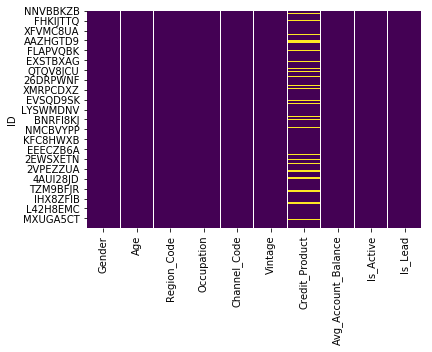

In [160]:
#checking nullvalues in each column through visualisation
sns.heatmap(df_train.isnull(), cbar=False, cmap='viridis')
#insight --> missing values only in one column i.e. credit_product

In [161]:
#missing value proportions
(df_train.isnull().sum()/len(df_train))*100
# insight --> more than 10% of a column is missing, hence cannot drop these rows

Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.935093
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [162]:
#Imputing missing values in training and test dataset.
df_train=df_train.fillna('Yes')
df_test_final= pd.read_csv('test_mSzZ8RL.csv')
df_test_final=df_test_final.fillna('Yes')

In [163]:
#setting index as ID in training and test datasets
df_test_final.set_index('ID',inplace=True)

In [164]:
#checking distribution of target variable
df_train['Is_Lead'].value_counts()
# insight --> imbalanced data, would use Startified K fold technique to build the model

0    187416
1     58288
Name: Is_Lead, dtype: int64

# Target Variable Distribution based on different features

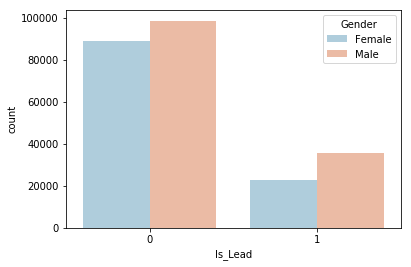

In [165]:
sns.countplot('Is_Lead', hue ='Gender', data=df_train, palette='RdBu_r')

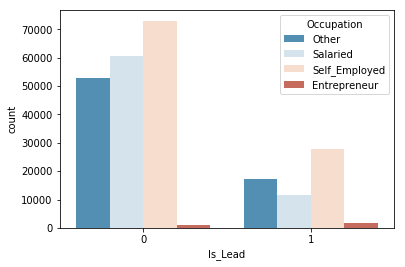

In [166]:
sns.countplot('Is_Lead', hue ='Occupation', data=df_train, palette='RdBu_r')

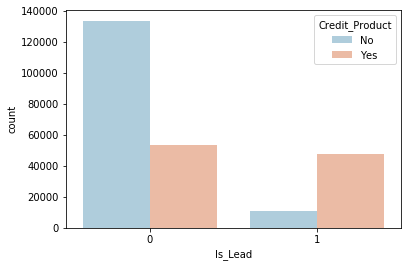

In [167]:
sns.countplot('Is_Lead', hue ='Credit_Product', data=df_train, palette='RdBu_r')

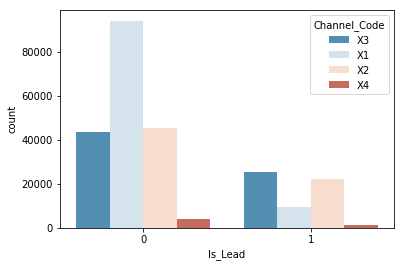

In [168]:
sns.countplot('Is_Lead', hue ='Channel_Code', data=df_train, palette='RdBu_r')

In [169]:
#categorical variables
cat_bool=df_train.dtypes=='object'
categorial_variables = list(cat_bool[cat_bool].index)
categorial_variables

['Gender',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Credit_Product',
 'Is_Active']

In [170]:
#numerical variables
num_bool=df_train.dtypes!='object'
numerical_variables = list(num_bool[num_bool].index)
print(numerical_variables)

['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead']


# Numerical Variables

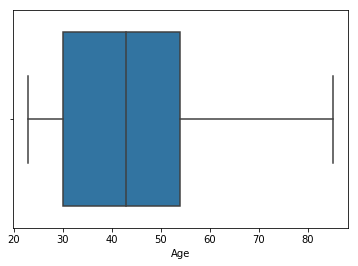

In [173]:
sns.boxplot('Age',data=df_train)
#no outliers

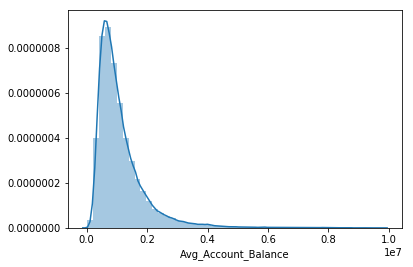

In [174]:
sns.distplot(df_train['Avg_Account_Balance'])

In [175]:
df_train = df_train[df_train['Avg_Account_Balance']<=max(df_test_final.Avg_Account_Balance)].reset_index(drop=True)
#treating outliers based on final test data

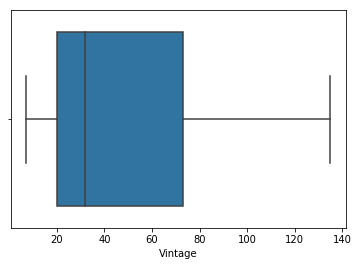

In [176]:
sns.boxplot('Vintage',data=df_train)
#no outliers

# Label Encoding Categorical Variables

In [178]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in categorial_variables:
    df_train[i] = le.fit_transform(df_train[i])
    df_test_final[i] = le.fit_transform(df_test_final[i])

# Modeling

In [179]:
X=df_train.drop(['Is_Lead'],axis=1)
y=df_train['Is_Lead']

In [180]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

def cross_val(X, y, model, params, folds=9):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-"*50)
    
    return alg

In [181]:
xgb_params= {'n_estimators': 20000, 
             'max_depth': 6, 
             'learning_rate': 0.0201, 
             'reg_lambda': 29.326, 
             'subsample': 0.818, 
             'colsample_bytree': 0.235, 
             'colsample_bynode': 0.820, 
             'colsample_bylevel': 0.453}

In [182]:
from xgboost import XGBClassifier
xgb_model = cross_val(X, y, XGBClassifier, xgb_params)

Fold: 0
[23:10:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68731
[400]	validation_0-logloss:0.40120
[800]	validation_0-logloss:0.39090
[1200]	validation_0-logloss:0.38868
[1600]	validation_0-logloss:0.38742
[2000]	validation_0-logloss:0.38657
[2400]	validation_0-logloss:0.38588
[2800]	validation_0-logloss:0.38548
[3200]	validation_0-logloss:0.38527
[3600]	validation_0-logloss:0.38511
[3860]	validation_0-logloss:0.38505
roc_auc_score: 0.8492045066110878
--------------------------------------------------
Fold: 1
[23:16:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logisti

# Final Submission

In [145]:
predictions = xgb_model.predict_proba(df_test_final)[:,1]

In [146]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['Is_Lead'] = predictions
sample_submission.to_csv(f'submission_final.csv',index=False)